<a href="https://colab.research.google.com/github/SergeiVKalinin/BO_Research/blob/master/ensembleDKL_window_sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensembled deep kernel learning with varying window sizes



## Installation

In [ ]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai  # we will use the atomai's utility function for preparing the input data

  Preparing metadata (setup.py) ... done


## Imports

In [ ]:
from warnings import filterwarnings

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks

import gpax
from atomai.utils import get_coord_grid, extract_patches_and_spectra

gpax.utils.enable_x64()

filterwarnings("ignore", module="haiku._src.data_structures")

## Prepared data

Download training data:

In [ ]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [ ]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [ ]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate image patches and vector targets (spectra) for the largest window size



In [ ]:
window_size = 24

coordinates = get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features = features.reshape(-1, window_size**2)

features.shape, targets.shape

Use the indices of the centers of the extracted patches to generate image patches of the smaller sizes in the same coordinates

In [ ]:
window_sizes = np.arange(2, window_size, 4)

features_all = []
for wsize in window_sizes:
    features_i, _, _ = extract_patches_and_spectra(
        specim, img, coordinates=indices, window_size=wsize, avg_pool=16)
    features_all.append(features_i.reshape(-1, wsize**2))

features_all.append(features)
window_sizes = np.append(window_sizes, window_size)

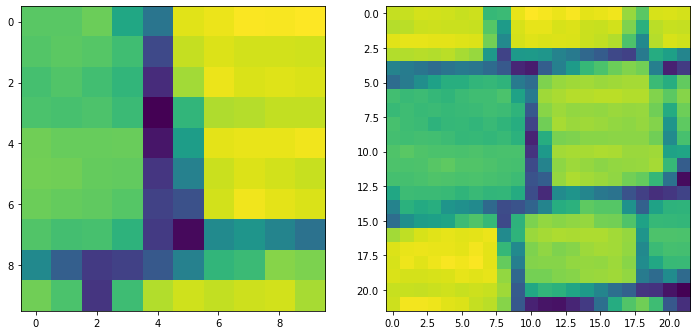

In [ ]:
k = 20
i, j = 2, 5

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(features_all[i][k].reshape(window_sizes[i], window_sizes[i]))
ax2.imshow(features_all[j][k].reshape(window_sizes[j], window_sizes[j]))

Normalize data:

In [ ]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features_all, targets = [norm_(f) for f in features_all], norm_(targets)

Next, we select a scalarizer function that will convert a measured spectrum into a scalar physical descriptor.

Here we are going to do the scalarization by simply using the intensity of the most prominent plasmonic peak, but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First, let's do it for a single spectrum:

25 0.2476621403207266


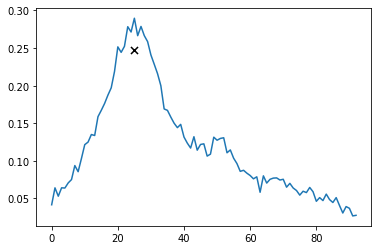

In [ ]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Now for all the data:

In [ ]:
targets_all, indices_to_use = [], []

for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    indices_to_use.append(i)
    targets_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)

features_all_ = [f[indices_to_use] for f in features_all]
features_all = features_all_

indices_all = indices[indices_to_use]
targets_all = np.array(targets_all).squeeze()

Plot the scalarized target values for each feature coordinate:

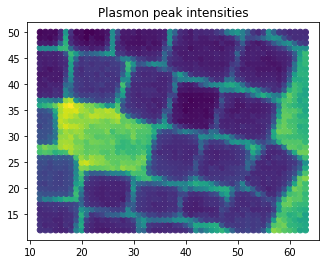

In [ ]:
_, ax = plt.subplots()
ax.scatter(indices_all[:, 1], indices_all[:, 0], c=targets_all)
ax.set_title('Plasmon peak intensities')
ax.set_aspect('equal')

Split data points into measured and unmeasured:

In [ ]:
idx = np.random.randint(0, len(targets_all), 5)

X_measured = [f[idx] for f in features_all]
y_measured = targets_all[idx]
X_unmeasured = [np.delete(f, idx, axis=0) for f in features_all]
y_unmeasured = np.delete(targets_all, idx, axis=0)

indices_measured = indices_all[idx]
indices_unmeasured = np.delete(indices_all, idx, axis=0)

num_seed_points = len(X_measured)

Define helper function

In [ ]:
def step(X_train, y_train, X_unmeasured):
    """Single Ensemble-DKL step"""
    key, _ = gpax.utils.get_keys()
    dkl = gpax.viDKL(X_train.shape[-1], z_dim=2, kernel='RBF')
    y_mu, y_sig = dkl.fit_predict(
        key, X_train, y_train, X_unmeasured,
        n_models=20, num_steps=2500, step_size=0.001)
    return y_mu.mean(0), y_sig.mean(0)

def update_datapoints(point_idx, point_measured, X, y, indices):
    """Updates measured and unmeasured arrays at the end of each exploration step"""
    # Unpack
    X_measured, X_unmeasured = X
    y_measured, y_unmeasured = y
    indices_measured, indices_unmeasured = indices
    # Update the arrays of measured/unmeasured points
    for i in range(len(X_measured)):
        X_measured[i] = np.append(X_measured[i], X_unmeasured[i][point_idx][None], 0)
        X_unmeasured[i] = np.delete(X_unmeasured[i], point_idx, 0)
    y_measured = np.append(y_measured, point_measured)
    y_unmeasured = np.delete(y_unmeasured, point_idx)
    indices_measured = np.append(indices_measured, indices_unmeasured[point_idx][None], 0)
    indices_unmeasured = np.delete(indices_unmeasured, point_idx, 0)

    return (X_measured, X_unmeasured), (y_measured, y_unmeasured), (indices_measured, indices_unmeasured)

Main loop

In [ ]:
# Initialize the reward and predictive uncertainty records
record = np.zeros((len(X_measured), 2))
obj_history = []

def compute_reward(obj_history):
    """Simple reward function"""
    r = 1 if obj_history[-1] < obj_history[-2] else -1
    return r

exploration_steps = 150

# Exploration phase
for e in range(exploration_steps):

    print("\nExploration step {}/{}".format(e+1, exploration_steps))

    # Sample window size according to softmax or epsilon-greedy selection policy
    idx = gpax.hypo.sample_next(
        rewards=record[:, 1], method="softmax", temperature=1.1)

    print("Using window size {}".format(window_sizes[idx]))

    # Derive predictive uncertainty with the selected window size
    mean, var = step(X_measured[idx], y_measured, X_unmeasured[idx])
    obj = var

    # Update predictive uncertainty records
    obj_history.append(jnp.nanmedian(obj).item())
    if e < 1:
        continue

    # Compute reward and update reward records
    r = compute_reward(obj_history)
    record = gpax.hypo.update_record(record, idx, r)

    # Derive the next measurement point
    next_point_idx = obj.argmax()
    # Make a "measurement" in the suggested point
    measured_point = y_unmeasured[next_point_idx]

    # Update arrays with measured and unmeasured data
    ((X_measured, X_unmeasured), (y_measured, y_unmeasured),
     (indices_measured, indices_unmeasured)) = update_datapoints(
        next_point_idx, measured_point, (X_measured, X_unmeasured),
        (y_measured, y_unmeasured), (indices_measured, indices_unmeasured))

    # Print the running rewards
    print("\nRewards:")
    for r, w in zip(record, window_sizes):
        print("window size {}:  counts {}  reward (avg) {}".format(w, (int(r[0])), np.round(r[1], 3)))


Exploration step 1/150
Using window size 6

Exploration step 2/150
Using window size 24

Rewards:
window size 2:  counts 0  reward (avg) 0.0
window size 6:  counts 0  reward (avg) 0.0
window size 10:  counts 0  reward (avg) 0.0
window size 14:  counts 0  reward (avg) 0.0
window size 18:  counts 0  reward (avg) 0.0
window size 22:  counts 0  reward (avg) 0.0
window size 24:  counts 1  reward (avg) 1.0

Exploration step 3/150
Using window size 10

Rewards:
window size 2:  counts 0  reward (avg) 0.0
window size 6:  counts 0  reward (avg) 0.0
window size 10:  counts 1  reward (avg) 1.0
window size 14:  counts 0  reward (avg) 0.0
window size 18:  counts 0  reward (avg) 0.0
window size 22:  counts 0  reward (avg) 0.0
window size 24:  counts 1  reward (avg) 1.0

Exploration step 4/150
Using window size 2

Rewards:
window size 2:  counts 1  reward (avg) 1.0
window size 6:  counts 0  reward (avg) 0.0
window size 10:  counts 1  reward (avg) 1.0
window size 14:  counts 0  reward (avg) 0.0
window

window size 2:  counts 15  reward (avg) -0.867
window size 6:  counts 13  reward (avg) -0.385
window size 10:  counts 24  reward (avg) -0.083
window size 14:  counts 5  reward (avg) -1.0
window size 18:  counts 17  reward (avg) 0.059
window size 22:  counts 34  reward (avg) 0.353
window size 24:  counts 41  reward (avg) 0.854


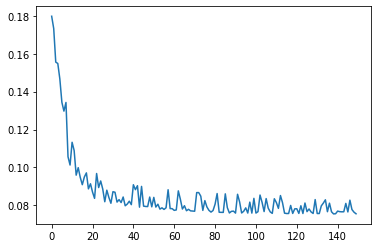

In [ ]:
plt.plot(obj_history)

for r, w in zip(record, window_sizes):
    print("window size {}:  counts {}  reward (avg) {}".format(w, (int(r[0])), np.round(r[1], 3)))

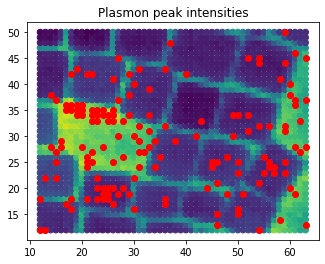

In [ ]:
_, ax = plt.subplots()
ax.scatter(indices_all[:, 1], indices_all[:, 0], c=targets_all)
ax.scatter(indices_measured[:, 1], indices_measured[:, 0], c='r')
ax.set_title('Plasmon peak intensities')
ax.set_aspect('equal')